# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.469530,True,4.421235
1,0.364827,True,4.988880
2,-1.299932,False,-0.136156
3,0.067169,True,6.577852
4,-0.665454,False,-0.572987
...,...,...,...
995,-1.580433,False,-1.023226
996,0.356308,True,8.042280
997,1.344990,True,5.104946
998,-0.034052,False,1.609208


<Axes: xlabel='v0'>

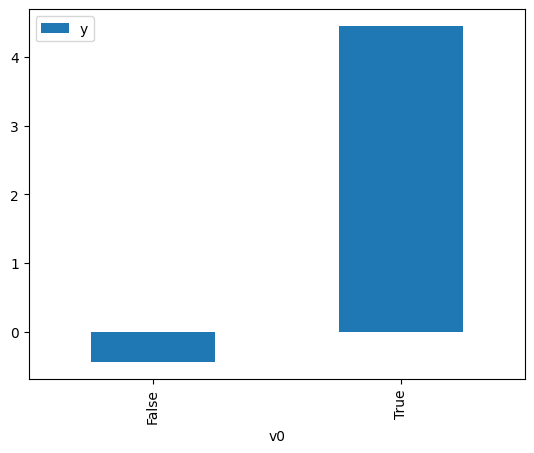

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

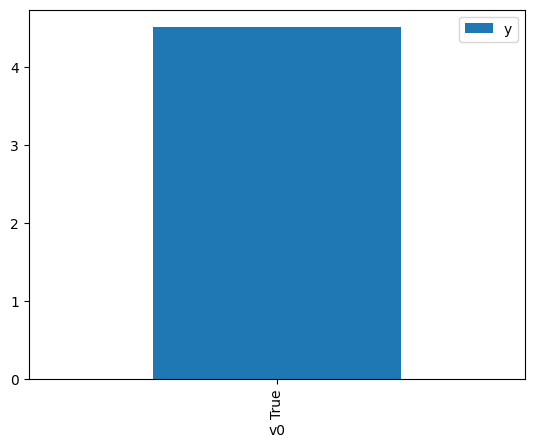

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.059417,False,-1.288756,0.873023,1.145446
1,-0.221926,False,0.363624,0.596721,1.675825
2,-0.909754,False,-1.997390,0.839355,1.191390
3,-1.800972,False,-2.197268,0.964019,1.037324
4,-0.688920,False,-0.284813,0.777020,1.286968
...,...,...,...,...,...
995,-0.924516,False,-1.678024,0.842973,1.186278
996,-0.118849,False,0.043284,0.550516,1.816478
997,-0.301086,False,1.506822,0.631118,1.584489
998,-0.933700,False,0.817418,0.845190,1.183166


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.583999,True,4.672944,0.258087,3.874669
1,-1.064691,True,5.285453,0.125909,7.942253
2,1.376796,True,6.800691,0.926937,1.078822
3,1.289307,True,5.667488,0.915297,1.092542
4,-1.284694,True,5.987281,0.087771,11.393263
...,...,...,...,...,...
995,-2.402446,True,2.674903,0.012233,81.749186
996,0.105011,True,5.960343,0.551776,1.812328
997,0.195031,True,5.677200,0.592176,1.688688
998,0.015102,True,3.493781,0.510733,1.957971


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                              4743.
Date:                Tue, 19 Nov 2024   Prob (F-statistic):                        0.00
Time:                        21:40:08   Log-Likelihood:                         -1472.7
No. Observations:                1000   AIC:                                      2949.
Df Residuals:                     998   BIC:                                      2959.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7571      0.029     25.917      0.000       0.700       0.814
x2             5.0239      0.056     88.989      0.000       4.913       5.135
==============================================================================
Omnibus:                        3.544   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                3.410
Skew:                           0.137   Prob(JB):                        0.182
Kurtosis:                       3.084   Cond. No.                         1.97
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""